In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier
from joblib import Parallel, delayed
from scipy.spatial import ConvexHull, Delaunay
from AA_Fast import AA_Fast
from sklearn.decomposition import PCA


In [2]:
def load_datasets_from_folder(folder_path):
    """Load all CSV datasets from a folder into a dictionary."""
    datasets = {}
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            try:
                datasets[os.path.splitext(file)[0]] = pd.read_csv(os.path.join(folder_path, file))
            except Exception as e:
                print(f"Warning: Failed to load {file} - {e}")
    return datasets

# Specify folder path
folder_path = r"\\wsl.localhost\Ubuntu\home\kleinr1\RF-Overample\datasets"

# Load datasets
datasets = load_datasets_from_folder(folder_path)

# Output results
print(f"Total datasets loaded successfully: {len(datasets)}")
print("Successfully loaded datasets:")
for name, df in datasets.items():
    print(f" - {name} (Rows: {len(df)}, Columns: {len(df.columns)})")


Total datasets loaded successfully: 30
Successfully loaded datasets:
 - tic-tac-toe (Rows: 958, Columns: 10)
 - heart_disease (Rows: 303, Columns: 14)
 - lymphography (Rows: 148, Columns: 19)
 - sonar (Rows: 208, Columns: 61)
 - flare1 (Rows: 323, Columns: 11)
 - crx (Rows: 664, Columns: 15)
 - hepatitis (Rows: 138, Columns: 16)
 - mnist_test (Rows: 10000, Columns: 785)
 - wine (Rows: 178, Columns: 14)
 - balance_scale (Rows: 625, Columns: 5)
 - seeds (Rows: 199, Columns: 8)
 - optdigits (Rows: 3823, Columns: 65)
 - glass (Rows: 214, Columns: 10)
 - breast_cancer (Rows: 699, Columns: 10)
 - artificial_tree (Rows: 5000, Columns: 41)
 - chess (Rows: 3196, Columns: 37)
 - ecoli_5 (Rows: 327, Columns: 8)
 - audiology (Rows: 190, Columns: 68)
 - titanic (Rows: 712, Columns: 8)
 - iris (Rows: 150, Columns: 5)
 - ionosphere (Rows: 351, Columns: 35)
 - parkinsons (Rows: 195, Columns: 23)
 - zoo (Rows: 101, Columns: 18)
 - hill_valley (Rows: 606, Columns: 101)
 - segmentation (Rows: 211, Column

In [3]:
class DatasetPreprocessor:
    def __init__(self, dataset, target_column=None, test_size=0.3, random_state=42, remove_categorical=False):
        """
        Initializes the DatasetPreprocessor.

        Args:
        - dataset (pd.DataFrame): The dataset to preprocess.
        - target_column (str, optional): The name of the target column. Defaults to the first column.
        - test_size (float): Proportion of dataset to allocate for testing.
        - random_state (int): Random seed for reproducibility.
        - remove_categorical (bool): If True, categorical variables are removed instead of being encoded.
        """
        self.dataset = dataset.copy()
        self.target_column = target_column if target_column else dataset.columns[0]
        self.test_size = test_size
        self.random_state = random_state
        self.remove_categorical = remove_categorical
        self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None
        self._prepare_data()

    def _prepare_data(self):
        # Separate features (X) and target (y)
        x = self.dataset.drop(columns=[self.target_column])
        y = self.dataset[self.target_column]

        # Identify categorical columns
        cat_cols = x.select_dtypes(include=["object", "category"]).columns

        if self.remove_categorical:
            # Drop categorical columns instead of encoding them
            x = x.drop(columns=cat_cols, errors='ignore')
            print(f"Removed categorical columns: {list(cat_cols)}")
        else:
            # Encode categorical columns
            if len(cat_cols) > 0:
                x[cat_cols] = x[cat_cols].apply(lambda col: col.astype("category").cat.codes)
                print(f"Encoded categorical columns: {list(cat_cols)}")

        # Train-test split
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            x, y, test_size=self.test_size, random_state=self.random_state
        )

        print("\nData Preparation Complete")
        print(f"Train-Test Split: Train ({len(self.x_train)}) | Test ({len(self.x_test)})")
        print(f"Feature Columns: {len(x.columns)} | Categorical Processed: {len(cat_cols)}\n")

        # specify encoding parameter


In [4]:
class ImbalanceHandler:
    def __init__(self, x_train, y_train, imbalance_ratio=0.2, batch_size=20, random_state=42):
        """
        Initializes the ImbalanceHandler class.

        Args:
            x_train (pd.DataFrame): Training feature set.
            y_train (pd.Series): Training labels.
            imbalance_ratio (float): Target imbalance ratio (default 0.2 for 20% minority).
            batch_size (int): The number of total samples per batch (default 20).
            random_state (int): Random seed for reproducibility.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.imbalance_ratio = imbalance_ratio
        self.batch_size = batch_size
        self.random_state = random_state

    def apply_resampling(self, df, n_samples):
        """Safely resamples the given DataFrame to ensure valid sample size."""
        n_samples = max(1, min(n_samples, len(df)))  # Ensure at least 1 sample but not more than available
        return resample(df, replace=False, n_samples=n_samples, random_state=self.random_state)

    def introduce_imbalance(self):
        """Introduces class imbalance while ensuring divisibility by batch_size."""
        print(f"\nApplying imbalance ratio: {self.imbalance_ratio:.2f}")

        # Combine features & labels
        train_df = pd.concat([self.x_train, self.y_train.to_frame()], axis=1)

        # Get class distributions
        class_counts = self.y_train.value_counts()
        print(f"\nOriginal Class Distribution:\n{class_counts.to_string()}")

        # Identify majority and minority class
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the classes
        minority_samples = train_df[train_df[self.y_train.name] == minority_class]
        majority_samples = train_df[train_df[self.y_train.name] == majority_class]

        # Adjust class sizes safely
        def adjust_class_size(df):
            adjusted_size = (len(df) // self.batch_size) * self.batch_size
            return self.apply_resampling(df, adjusted_size)

        minority_samples = adjust_class_size(minority_samples)
        majority_samples = adjust_class_size(majority_samples)

        print(f"\nAdjusted Sizes - Minority: {len(minority_samples)}, Majority: {len(majority_samples)}")

        # Apply Imbalance Ratio
        minority_per_batch = max(1, int(self.batch_size * self.imbalance_ratio))
        majority_per_batch = max(1, self.batch_size - minority_per_batch)

        # Ensure we have enough samples to run at least one iteration
        max_iterations = min(
            len(minority_samples) // minority_per_batch,
            len(majority_samples) // majority_per_batch
        )

        if max_iterations == 0:
            print("[WARNING] Not enough samples to introduce the desired imbalance ratio. Returning original dataset.")
            return self.x_train, self.y_train

        final_samples = [
            pd.concat([
                self.apply_resampling(minority_samples, minority_per_batch),
                self.apply_resampling(majority_samples, majority_per_batch)
            ])
            for _ in range(max_iterations)
        ]

        # Combine and shuffle
        imbalanced_train_df = pd.concat(final_samples).sample(frac=1, random_state=self.random_state).reset_index(drop=True)

        print(f"\nNew Class Distribution:\n{imbalanced_train_df[self.y_train.name].value_counts().to_string()}")

        return imbalanced_train_df.drop(columns=[self.y_train.name]), imbalanced_train_df[self.y_train.name]
    
    # Percentage of minority class for archetypal analysis.(number of archetypes). (percentage)


In [5]:
class ResamplingHandler:
    def __init__(self, x_train, y_train, random_state=42):
        self.x_train = x_train
        self.y_train = y_train
        self.random_state = random_state

    def apply_smote(self):
        """Applies SMOTE and returns the resampled dataset."""
        smote = SMOTE(random_state=self.random_state)
        x_resampled, y_resampled = smote.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled

    def apply_adasyn(self):
        """Applies ADASYN and returns the resampled dataset."""
        adasyn = ADASYN(random_state=self.random_state)
        x_resampled, y_resampled = adasyn.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled

    def apply_random_undersampling(self):
        """Applies Random Undersampling and returns the resampled dataset."""
        rus = RandomUnderSampler(random_state=self.random_state)
        x_resampled, y_resampled = rus.fit_resample(self.x_train, self.y_train)
        return x_resampled, y_resampled


In [6]:
class ModelTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, random_state=42):
        """
        Initializes the ModelTrainer.

        Args:
            x_train (pd.DataFrame): Training feature set.
            y_train (pd.Series): Training labels.
            x_test (pd.DataFrame): Testing feature set.
            y_test (pd.Series): Testing labels.
            random_state (int): Random seed for reproducibility.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.random_state = random_state
        self.model = None

        # Store original imbalanced data for reset purposes
        self.imbalanced_x_train = x_train.copy()
        self.imbalanced_y_train = y_train.copy()

    def reset_training_data(self):
        """Resets x_train and y_train back to the original imbalanced dataset."""
        self.x_train = self.imbalanced_x_train.copy()
        self.y_train = self.imbalanced_y_train.copy()

    def train_and_evaluate(self, method="none", max_depth=2, n_estimators=100):
        """
        Trains and evaluates a model based on the specified resampling method.

        Args:
            method (str): Resampling method (options: "none", "class_weights", "smote", "adasyn", "random_undersampling", "easy_ensemble").
            max_depth (int): Max depth for RandomForestClassifier.
            n_estimators (int): Number of estimators for EasyEnsembleClassifier.

        Returns:
            pd.DataFrame: A classification report formatted for visualization.
        """
        self.reset_training_data()

        print(f"\n[INFO] Training with method: {method.upper()}")
        print("Class distribution before training:\n", self.y_train.value_counts(normalize=True))

        # Model Selection
        if method == "none":
            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)

        elif method == "class_weights":
            model = RandomForestClassifier(max_depth=max_depth, class_weight="balanced", random_state=self.random_state)

        elif method in ["smote", "adasyn", "random_undersampling"]:
            resampler = ResamplingHandler(self.x_train, self.y_train)

            if method == "smote":
                self.x_train, self.y_train = resampler.apply_smote()
            elif method == "adasyn":
                self.x_train, self.y_train = resampler.apply_adasyn()
            elif method == "random_undersampling":
                self.x_train, self.y_train = resampler.apply_random_undersampling()

            model = RandomForestClassifier(max_depth=max_depth, random_state=self.random_state)

        elif method == "easy_ensemble":
            model = EasyEnsembleClassifier(n_estimators=n_estimators, random_state=self.random_state)

        else:
            raise ValueError(f"Invalid method specified: {method}. Choose from ['none', 'class_weights', 'smote', 'adasyn', 'random_undersampling', 'easy_ensemble'].")

        # Train the model
        model.fit(self.x_train, self.y_train)
        self.model = model  

        # Predictions
        predictions = model.predict(self.x_test)

        # Generate classification report as a DataFrame
        report_dict = classification_report(self.y_test, predictions, output_dict=True)
        report_df = pd.DataFrame(report_dict).T  # Keep correct structure

        # Ensure accuracy is explicitly included
        if "accuracy" not in report_df.index:
            report_df.loc["accuracy"] = [report_dict["accuracy"], None, None, None]

        print("\n[INFO] Model Evaluation Complete")
        return report_df


In [7]:
class ExperimentRunner:
    """Runs multiple dataset configurations with different imbalance techniques and models."""
    
    def __init__(self, target_column=None, n_jobs=-1):
        """
        Args:
            target_column (str, optional): The target column to be used. Defaults to the first column in the dataset.
        """
        self.target_column = target_column
        self.n_jobs = n_jobs  

    def run_multiple_configs(self, datasets, methods, imbalance_ratios):
        """
        Runs experiments with different datasets, methods, and imbalance ratios in parallel.

        Args:
            datasets (dict): Dictionary of dataset names mapped to their DataFrame.
            methods (list): List of imbalance handling methods (e.g., ["none", "smote", "adasyn", "random_undersampling"]).
            imbalance_ratios (list): List of imbalance ratios to test (e.g., [0.1, 0.2, 0.3]).

        Returns:
            list: A list of dictionaries containing experiment results.
        """
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._run_single_config)(name, dataset, method, ratio)
            for name, dataset in datasets.items()
            for method in methods
            for ratio in imbalance_ratios
        )

        return results

    def _run_single_config(self, dataset_name, dataset, method, imbalance_ratio):
        """
        Runs a single configuration of dataset preprocessing, imbalance handling, resampling, and model training.

        Args:
            dataset_name (str): Name of the dataset.
            dataset (pd.DataFrame): The dataset being processed.
            method (str): Imbalance handling method.
            imbalance_ratio (float): Target imbalance ratio.

        Returns:
            dict: A dictionary containing experiment results or an error message.
        """
        try:
            target_column = self.target_column if self.target_column else dataset.columns[0]

            # Step 1: Preprocess dataset
            preprocessor = DatasetPreprocessor(dataset, target_column=target_column)
            x_train, x_test, y_train, y_test = (
                preprocessor.x_train,
                preprocessor.x_test,
                preprocessor.y_train,
                preprocessor.y_test,
            )

            # Step 2: Apply ImbalanceHandler (always applied, even for "none" method)
            imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio)
            x_train, y_train = imbalance_handler.introduce_imbalance()

            # Step 3: Apply resampling only if needed
            if method in ["smote", "adasyn", "random_undersampling"]:
                resampler = ResamplingHandler(x_train, y_train)

                if method == "smote":
                    x_train, y_train = resampler.apply_smote()
                elif method == "adasyn":
                    x_train, y_train = resampler.apply_adasyn()
                elif method == "random_undersampling":
                    x_train, y_train = resampler.apply_random_undersampling()

            # Step 4: Train model & evaluate
            trainer = ModelTrainer(x_train, y_train, x_test, y_test)
            result = trainer.train_and_evaluate(method=method)

            return {
                "dataset": dataset_name,
                "method": method,
                "imbalance_ratio": imbalance_ratio,
                "classification_report": result,
            }

        except Exception as e:
            return {
                "dataset": dataset_name,
                "method": method,
                "imbalance_ratio": imbalance_ratio,
                "error": str(e),
            }

In [8]:
def baseline(dataset, target_column=None, imbalance_ratio=None):
    """
    Runs the upper baseline by training a RandomForestClassifier on the original dataset 
    or optionally an imbalanced dataset (if imbalance_ratio is set).

    Args:
        dataset (pd.DataFrame): The dataset to process.
        target_column (str, optional): The column to use as the target. Defaults to the first column.
        imbalance_ratio (float, optional): If set, applies custom class imbalance.

    Returns:
        dict: A dictionary containing the weighted F1-score and classification report.
    """
    try:
        dataset_name = dataset.name if hasattr(dataset, "name") else "Unnamed Dataset"

        # Step 1: Preprocess the dataset
        preprocessor = DatasetPreprocessor(dataset, target_column=target_column)
        x_train, x_test, y_train, y_test = (
            preprocessor.x_train, 
            preprocessor.x_test, 
            preprocessor.y_train, 
            preprocessor.y_test
        )

        # Step 2: Apply Custom Imbalance Handling if imbalance_ratio is set
        if imbalance_ratio is not None:
            imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio=imbalance_ratio)
            x_train, y_train = imbalance_handler.introduce_imbalance()  # Use imbalanced data

            print(f"\n[INFO] Applied custom imbalance ratio: {imbalance_ratio:.2f}")
            print("Updated Class Distribution:\n", y_train.value_counts())

        # Step 3: Train and Evaluate Model (no resampling)
        trainer = ModelTrainer(x_train, y_train, x_test, y_test)
        report_df = trainer.train_and_evaluate(method="none")  # Train without additional resampling

        # Step 4: Extract Weighted F1 Score
        f1_score_baseline = report_df.loc["weighted avg", "f1-score"]

        # Print Results
        print(f"\n[BASELINE] Dataset: {dataset_name}")
        print(f"[BASELINE] Imbalance Handling: {'Custom Imbalance' if imbalance_ratio else 'Original Data'}")
        print(f"[BASELINE] Weighted F1 Score: {f1_score_baseline:.4f}")
        print("[BASELINE] Classification Report:\n", report_df)

        return {
            "dataset": dataset_name,
            "method": "Custom Imbalance" if imbalance_ratio else "none",
            "imbalance_ratio": imbalance_ratio if imbalance_ratio else "original",
            "f1_score": f1_score_baseline,
            "classification_report": report_df
        }
    
    except Exception as e:
        print("[ERROR] Baseline model failed:", str(e))
        return {"error": str(e)}

# Run modified baseline with ImbalanceHandler
baseline_results = baseline(datasets["titanic"], imbalance_ratio=None)


Encoded categorical columns: ['Sex', 'Embarked']

Data Preparation Complete
Train-Test Split: Train (498) | Test (214)
Feature Columns: 7 | Categorical Processed: 2


[INFO] Training with method: NONE
Class distribution before training:
 Survived
0    0.606426
1    0.393574
Name: proportion, dtype: float64

[INFO] Model Evaluation Complete

[BASELINE] Dataset: Unnamed Dataset
[BASELINE] Imbalance Handling: Original Data
[BASELINE] Weighted F1 Score: 0.7564
[BASELINE] Classification Report:
               precision    recall  f1-score     support
0              0.736842  0.918033  0.817518  122.000000
1              0.838710  0.565217  0.675325   92.000000
accuracy       0.766355  0.766355  0.766355    0.766355
macro avg      0.787776  0.741625  0.746421  214.000000
weighted avg   0.780636  0.766355  0.756388  214.000000


In [9]:
# Generalized Experiment Runner Implementation

# Specify methods and imbalance ratios
methods = ["none", "smote", "class_weights", "random_undersampling", "adasyn", "easy_ensemble"]
imbalance_ratios = [0.3]

# Initialize ExperimentRunner
experiment_runner = ExperimentRunner(target_column=None, n_jobs=-1)

# Run experiments on a single dataset (Titanic)
results = experiment_runner.run_multiple_configs(
    datasets={"titanic": datasets["titanic"]},  # Pass only the Titanic dataset
    methods=methods, 
    imbalance_ratios=imbalance_ratios
)

print(results)

[{'dataset': 'titanic', 'method': 'none', 'imbalance_ratio': 0.3, 'classification_report':               precision    recall  f1-score     support
0              0.708609  0.877049  0.783883  122.000000
1              0.761905  0.521739  0.619355   92.000000
accuracy       0.724299  0.724299  0.724299    0.724299
macro avg      0.735257  0.699394  0.701619  214.000000
weighted avg   0.731521  0.724299  0.713151  214.000000}, {'dataset': 'titanic', 'method': 'smote', 'imbalance_ratio': 0.3, 'classification_report':               precision    recall  f1-score     support
0              0.718121  0.877049  0.789668  122.000000
1              0.769231  0.543478  0.636943   92.000000
accuracy       0.733645  0.733645  0.733645    0.733645
macro avg      0.743676  0.710264  0.713305  214.000000
weighted avg   0.740093  0.733645  0.724010  214.000000}, {'dataset': 'titanic', 'method': 'class_weights', 'imbalance_ratio': 0.3, 'classification_report':               precision    recall  f1-score


Cleaned Experiment Results:
   Dataset                Method Imbalance Ratio  Weighted F1 Score
0  titanic                  none             0.3           0.713151
1  titanic                 smote             0.3           0.724010
2  titanic         class_weights             0.3           0.730409
3  titanic  random_undersampling             0.3           0.724010
4  titanic         easy_ensemble             0.3           0.609001


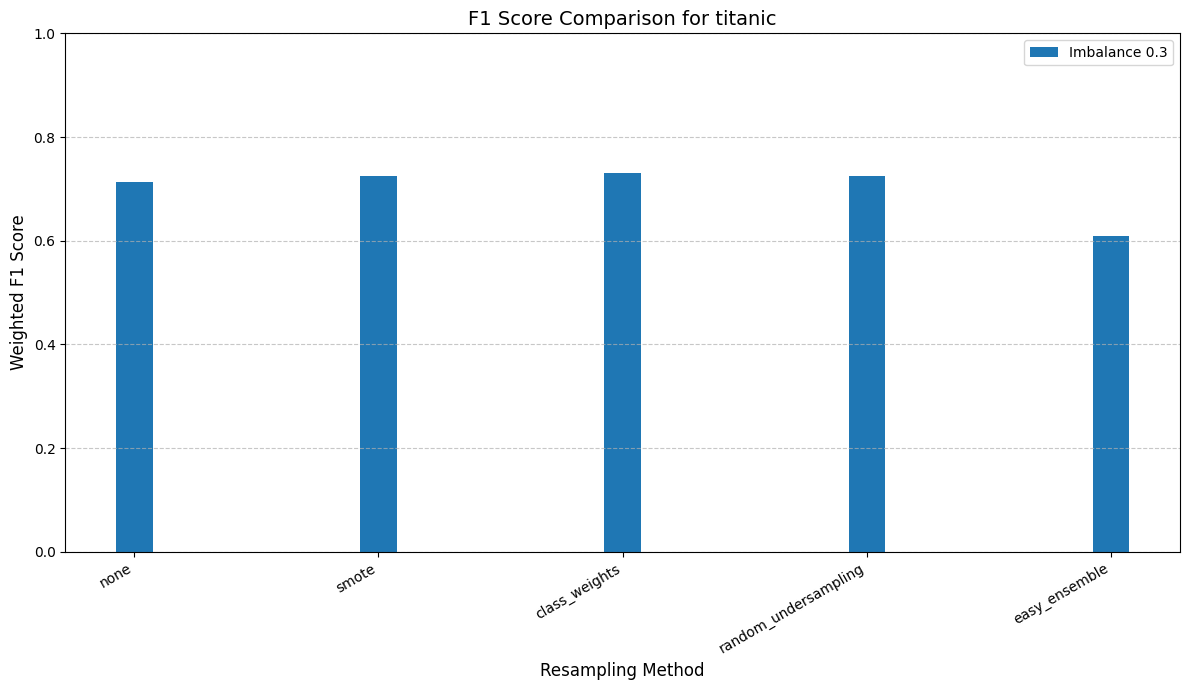

In [10]:
# Convert results to DataFrame, filtering out failed runs
valid_results = [res for res in results if "classification_report" in res]  
results_df = pd.DataFrame(valid_results)

# Function to extract Weighted F1 Score from classification report DataFrame
def extract_f1_score(report_df):
    try:
        # Ensure it's a DataFrame, then extract the weighted F1-score
        if isinstance(report_df, pd.DataFrame) and "weighted avg" in report_df.index:
            return report_df.loc["weighted avg", "f1-score"]
        return np.nan
    except Exception as e:
        return np.nan  # Return NaN if extraction fails

# Apply the function to extract Weighted F1 Scores
results_df["Weighted F1 Score"] = results_df["classification_report"].apply(extract_f1_score)

# Rename columns for consistency
results_df.rename(columns={"dataset": "Dataset", 
                           "method": "Method", 
                           "imbalance_ratio": "Imbalance Ratio"}, inplace=True)

# Ensure 'Weighted F1 Score' is numeric and handle any NaNs
results_df["Weighted F1 Score"] = pd.to_numeric(results_df["Weighted F1 Score"], errors="coerce")

# Handle "N/A" imbalance ratios (convert to a common format)
results_df["Imbalance Ratio"] = results_df["Imbalance Ratio"].astype(str).replace("N/A", "Original")

# Display the cleaned results DataFrame
print("\nCleaned Experiment Results:")
print(results_df[["Dataset", "Method", "Imbalance Ratio", "Weighted F1 Score"]])

# Function to visualize F1 Scores
def plot_f1_scores(results_df):
    datasets = results_df["Dataset"].unique()
    
    for dataset in datasets:
        df = results_df[results_df["Dataset"] == dataset]

        plt.figure(figsize=(12, 7))

        # Extract unique methods and imbalance ratios
        methods = df["Method"].unique()
        x = np.arange(len(methods))  # Label positions
        width = 0.15  # Bar width

        # Separate "Original" dataset results
        original_df = df[df["Imbalance Ratio"] == "Original"]
        non_original_df = df[df["Imbalance Ratio"] != "Original"]

        # Plot the "Original" dataset as a reference bar
        if not original_df.empty:
            plt.bar(x - width, original_df["Weighted F1 Score"], width=width, color="red", label="Original Dataset")

        # Loop through each imbalance ratio (excluding "Original")
        imbalance_ratios = non_original_df["Imbalance Ratio"].unique()
        for i, ratio in enumerate(imbalance_ratios):
            subset = non_original_df[non_original_df["Imbalance Ratio"] == ratio]
            plt.bar(x + i * width, subset["Weighted F1 Score"], width=width, label=f"Imbalance {ratio}")

        # Formatting
        plt.xticks(x, methods, rotation=30, ha="right", fontsize=10)
        plt.xlabel("Resampling Method", fontsize=12)
        plt.ylabel("Weighted F1 Score", fontsize=12)
        plt.title(f"F1 Score Comparison for {dataset}", fontsize=14)
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # Show plot
        plt.tight_layout()  # Ensure layout doesn't get cut off
        plt.show()

# Call function to visualize results
plot_f1_scores(results_df)


In [ ]:
def count_column_types(datasets):
    """
    Counts the number of categorical and numerical columns for each dataset and checks if 
    the predictor (default first column) has exactly 2 unique values.

    Args:
        datasets (dict): Dictionary of dataset names mapped to their DataFrame.

    Returns:
        pd.DataFrame: Summary table with counts of categorical and numerical columns,
                      and a flag indicating if the predictor is binary.
    """
    summary = []

    for name, df in datasets.items():
        num_categorical = len(df.select_dtypes(include=["object", "category"]).columns)
        num_numerical = len(df.select_dtypes(include=[np.number]).columns)
        
        # Determine the predictor column (defaults to first column)
        predictor_column = df.columns[0]
        is_binary = df[predictor_column].nunique() == 2  # Check if only 2 unique values exist

        summary.append({
            "Dataset": name,
            "Categorical Columns": num_categorical,
            "Numerical Columns": num_numerical,
            "Binary Predictor": is_binary
        })

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary)

    # Optional: Filter for datasets that have a binary predictor
    binary_datasets = summary_df[summary_df["Binary Predictor"]]

    return summary_df, binary_datasets

# Run the function and display results
column_summary, binary_dataset_summary = count_column_types(datasets)
print(column_summary)

            Dataset  Categorical Columns  Numerical Columns  Binary Predictor
0       tic-tac-toe                   10                  0              True
1     heart_disease                    2                 12             False
2      lymphography                    0                 19             False
3             sonar                    1                 60              True
4            flare1                    3                  8             False
5               crx                    9                  6              True
6         hepatitis                    0                 16              True
7        mnist_test                    0                785             False
8              wine                    0                 14             False
9     balance_scale                    1                  4             False
10            seeds                    0                  8             False
11        optdigits                    0                 65     

In [12]:
# Step 1: Load the Titanic Dataset
df = datasets["crx"]

# Step 2: Preprocess the dataset
# Standard preprocessing (keeps categorical variables)
preprocessor_cat = DatasetPreprocessor(df, remove_categorical=False)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = (
    preprocessor_cat.x_train, preprocessor_cat.x_test, 
    preprocessor_cat.y_train, preprocessor_cat.y_test
)

# Preprocessing without categorical variables
preprocessor_no_cat = DatasetPreprocessor(df, remove_categorical=True)
X_train_no_cat, X_test_no_cat, y_train_no_cat, y_test_no_cat = (
    preprocessor_no_cat.x_train, preprocessor_no_cat.x_test, 
    preprocessor_no_cat.y_train, preprocessor_no_cat.y_test
)

# Step 3: Introduce Class Imbalance (80% majority, 20% minority)
imbalance_handler_cat = ImbalanceHandler(X_train_cat, y_train_cat, imbalance_ratio=0.2)
X_train_imbalanced_cat, y_train_imbalanced_cat = imbalance_handler_cat.introduce_imbalance()

imbalance_handler_no_cat = ImbalanceHandler(X_train_no_cat, y_train_no_cat, imbalance_ratio=0.2)
X_train_imbalanced_no_cat, y_train_imbalanced_no_cat = imbalance_handler_no_cat.introduce_imbalance()

# 🔹 Ensure each method starts with the same imbalanced dataset
X_train_baseline = X_train_imbalanced_cat.copy()
y_train_baseline = y_train_imbalanced_cat.copy()

X_train_smote_full = X_train_imbalanced_cat.copy()
y_train_smote_full = y_train_imbalanced_cat.copy()

X_train_aa_cat = X_train_imbalanced_cat.copy()
y_train_aa_cat = y_train_imbalanced_cat.copy()

X_train_aa_no_cat = X_train_imbalanced_no_cat.copy()
y_train_aa_no_cat = y_train_imbalanced_no_cat.copy()

# Step 4: Define function to run Archetypal Analysis on separate classes
def run_archetypal_analysis(X, y, n_archetypes=10):
    """
    Runs Archetypal Analysis separately for majority and minority classes.

    Args:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target labels.
        n_archetypes (int): Number of archetypes to extract.

    Returns:
        pd.DataFrame: Archetypal points for the minority class.
    """
    minority_class = y.value_counts().idxmin()
    majority_class = y.value_counts().idxmax()

    # Separate majority and minority class samples
    X_minority = X[y == minority_class]
    X_majority = X[y == majority_class]

    # Convert to numpy arrays
    X_minority_array = X_minority.to_numpy()

    # Run Archetypal Analysis on minority class only
    aa_minority = AA_Fast(n_archetypes=min(n_archetypes, len(X_minority_array)))
    aa_minority.fit(X_minority_array)

    # Extract archetypes (focus only on the minority class for oversampling)
    archetypes_minority = pd.DataFrame(aa_minority.Z, columns=X_minority.columns)

    return archetypes_minority, X_majority

# Step 5: Generate synthetic data using SMOTE on archetypal points
def smote_on_archetypes(X_majority, X_archetypes_minority, y_train):
    """
    Applies SMOTE only on the minority archetypal points while retaining majority class samples.

    Args:
        X_majority (pd.DataFrame): The full majority class dataset.
        X_archetypes_minority (pd.DataFrame): Archetypal points from the minority class.
        y_train (pd.Series): Target labels.

    Returns:
        pd.DataFrame, pd.Series: Synthetic feature dataset and labels.
    """
    minority_class = y_train.value_counts().idxmin()
    majority_class = y_train.value_counts().idxmax()

    # Merge majority class with only minority archetypes
    X_combined = pd.concat([X_majority, X_archetypes_minority], ignore_index=True)
    y_combined = pd.concat([
        pd.Series([majority_class] * len(X_majority)), 
        pd.Series([minority_class] * len(X_archetypes_minority))
    ], ignore_index=True)

    # Apply SMOTE to generate synthetic samples for the minority class
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_combined, y_combined)

    # Extract only the newly generated synthetic samples
    synthetic_mask = (y_smote == minority_class) & (X_smote.index >= len(X_combined))
    X_synthetic = X_smote.loc[synthetic_mask]
    y_synthetic = y_smote.loc[synthetic_mask]

    return X_synthetic, y_synthetic

# Step 6: Compare Different Approaches
# SMOTE on the full imbalanced dataset
resampler_smote = ResamplingHandler(X_train_smote_full, y_train_smote_full)
X_train_smote, y_train_smote = resampler_smote.apply_smote()

# Archetypal Analysis before SMOTE (Keeping categorical variables)
X_archetypes_minority_categorical, X_majority_categorical = run_archetypal_analysis(
    X_train_aa_cat, y_train_aa_cat
)
X_synthetic_categorical, y_synthetic_categorical = smote_on_archetypes(
    X_majority_categorical, X_archetypes_minority_categorical, y_train_aa_cat
)

X_train_aa_smote_cat = pd.concat([X_train_aa_cat, X_synthetic_categorical], ignore_index=True)
y_train_aa_smote_cat = pd.concat([y_train_aa_cat, pd.Series(y_synthetic_categorical)], ignore_index=True)

# Archetypal Analysis before SMOTE (Dropping categorical variables)
X_archetypes_minority_no_cat, X_majority_no_cat = run_archetypal_analysis(
    X_train_aa_no_cat, y_train_aa_no_cat
)
X_synthetic_no_cat, y_synthetic_no_cat = smote_on_archetypes(
    X_majority_no_cat, X_archetypes_minority_no_cat, y_train_aa_no_cat
)

X_train_aa_smote_no_cat = pd.concat([X_train_aa_no_cat, X_synthetic_no_cat], ignore_index=True)
y_train_aa_smote_no_cat = pd.concat([y_train_aa_no_cat, pd.Series(y_synthetic_no_cat)], ignore_index=True)

# Step 7: Train Random Forest Models and Compare
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_aa_smote_cat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_aa_smote_no_cat = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models on different datasets
rf_baseline.fit(X_train_baseline, y_train_baseline)  # Baseline
rf_smote.fit(X_train_smote, y_train_smote)  # SMOTE only
rf_aa_smote_cat.fit(X_train_aa_smote_cat, y_train_aa_smote_cat)  # Archetypal Analysis + SMOTE (Categorical)
rf_aa_smote_no_cat.fit(X_train_aa_smote_no_cat, y_train_aa_smote_no_cat)  # Archetypal Analysis + SMOTE (No Categorical)

# Step 8: Evaluate Models on the Same Test Set
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Evaluate all models
evaluate_model(rf_baseline, X_test_cat, y_test_cat, "Baseline (Imbalanced Data)")
evaluate_model(rf_smote, X_test_cat, y_test_cat, "SMOTE on Full Dataset")
evaluate_model(rf_aa_smote_cat, X_test_cat, y_test_cat, "Archetypal SMOTE (With Categorical Variables)")
evaluate_model(rf_aa_smote_no_cat, X_test_no_cat, y_test_no_cat, "Archetypal SMOTE (Without Categorical Variables)")


Encoded categorical columns: ['0', '3', '4', '5', '6', '8', '9', '11', '12']

Data Preparation Complete
Train-Test Split: Train (464) | Test (200)
Feature Columns: 14 | Categorical Processed: 9

Removed categorical columns: ['0', '3', '4', '5', '6', '8', '9', '11', '12']

Data Preparation Complete
Train-Test Split: Train (464) | Test (200)
Feature Columns: 5 | Categorical Processed: 9


Applying imbalance ratio: 0.20

Original Class Distribution:
outcome
0    248
1    216

Adjusted Sizes - Minority: 200, Majority: 240

New Class Distribution:
outcome
0    240
1     60

Applying imbalance ratio: 0.20

Original Class Distribution:
outcome
0    248
1    216

Adjusted Sizes - Minority: 200, Majority: 240

New Class Distribution:
outcome
0    240
1     60

Baseline (Imbalanced Data) Performance:
Accuracy: 0.7200
F1 Score: 0.6857
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.97      0.80       118
           1       0.88      0.

Encoded categorical columns: ['Sex', 'Embarked']

Data Preparation Complete
Train-Test Split: Train (498) | Test (214)
Feature Columns: 7 | Categorical Processed: 2


Applying imbalance ratio: 0.20

Original Class Distribution:
Survived
0    302
1    196

Adjusted Sizes - Minority: 180, Majority: 300

New Class Distribution:
Survived
0    288
1     72


C:\Users\potat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


PCA explained variance ratio: [9.75377434e-01 2.38514966e-02 5.69961817e-04]
[INFO] Using 2D Convex Hull due to low PCA variance or too few unique points.


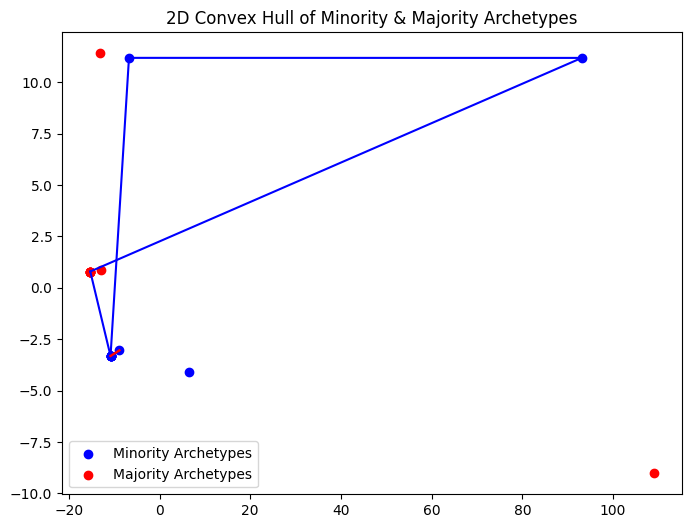


Baseline (Imbalanced Data) Performance:
Accuracy: 0.6449
F1 Score: 0.6114
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.89      0.74       122
           1       0.68      0.33      0.44        92

    accuracy                           0.64       214
   macro avg       0.66      0.61      0.59       214
weighted avg       0.66      0.64      0.61       214

Confusion Matrix:
 [[108  14]
 [ 62  30]]

SMOTE on Minority Archetypes Performance:
Accuracy: 0.6729
F1 Score: 0.6524
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.87      0.75       122
           1       0.70      0.41      0.52        92

    accuracy                           0.67       214
   macro avg       0.68      0.64      0.64       214
weighted avg       0.68      0.67      0.65       214

Confusion Matrix:
 [[106  16]
 [ 54  38]]


In [13]:
# Step 1: Load and Preprocess Titanic Dataset
df = datasets["titanic"]
preprocessor = DatasetPreprocessor(df)
X_train, X_test, y_train, y_test = preprocessor.x_train, preprocessor.x_test, preprocessor.y_train, preprocessor.y_test

# Step 2: Introduce Class Imbalance
imbalance_handler = ImbalanceHandler(X_train, y_train, imbalance_ratio=0.2)
X_train_imbalanced, y_train_imbalanced = imbalance_handler.introduce_imbalance()

# Step 3: Separate Data by Class
minority_class = y_train_imbalanced.value_counts().idxmin()
majority_class = y_train_imbalanced.value_counts().idxmax()

X_minority = X_train_imbalanced[y_train_imbalanced == minority_class]
X_majority = X_train_imbalanced[y_train_imbalanced == majority_class]

# Step 4: Apply Archetypal Analysis Separately for Majority and Minority Class
n_archetypes = 10

# Archetypal Analysis for Minority Class
aa_model_minority = AA_Fast(n_archetypes=n_archetypes)
aa_model_minority.fit(X_minority.to_numpy())
archetypes_minority = aa_model_minority.Z

# Archetypal Analysis for Majority Class
aa_model_majority = AA_Fast(n_archetypes=n_archetypes)
aa_model_majority.fit(X_majority.to_numpy())
archetypes_majority = aa_model_majority.Z

# Step 5: Reassign Labels to Archetypes Using Nearest Neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train_imbalanced)

# Find the closest real data points for each archetype
_, indices = nn.kneighbors(np.vstack([archetypes_minority, archetypes_majority]))
archetype_labels = y_train_imbalanced.iloc[indices.flatten()].values  # Assign real labels

# Step 6: Combine Archetypes and Their Reassigned Labels
archetypes_labeled = np.vstack([archetypes_minority, archetypes_majority])
y_archetypes_labeled = pd.Series(archetype_labels)

# Step 7: Reduce Dimensionality Using PCA
pca = PCA(n_components=3)
archetypes_reduced = pca.fit_transform(archetypes_labeled)

# Check variance explained by PCA components
pca_variance = pca.explained_variance_ratio_
print(f"PCA explained variance ratio: {pca_variance}")

# Step 8: Visualize Archetypes and Convex Hull
fig = plt.figure(figsize=(8, 6))

if pca_variance[2] > 0.01 and len(np.unique(archetypes_reduced, axis=0)) >= 4:
    ax = fig.add_subplot(111, projection="3d")

    # Convex Hull for Minority Class Archetypes
    hull_minority = ConvexHull(archetypes_reduced[y_archetypes_labeled == minority_class])
    ax.scatter(archetypes_reduced[y_archetypes_labeled == minority_class, 0],
               archetypes_reduced[y_archetypes_labeled == minority_class, 1],
               archetypes_reduced[y_archetypes_labeled == minority_class, 2], color='blue', label="Minority Archetypes")
    
    for simplex in hull_minority.simplices:
        ax.plot(archetypes_reduced[simplex, 0], archetypes_reduced[simplex, 1], archetypes_reduced[simplex, 2], 'b-')

    # Convex Hull for Majority Class Archetypes
    hull_majority = ConvexHull(archetypes_reduced[y_archetypes_labeled == majority_class])
    ax.scatter(archetypes_reduced[y_archetypes_labeled == majority_class, 0],
               archetypes_reduced[y_archetypes_labeled == majority_class, 1],
               archetypes_reduced[y_archetypes_labeled == majority_class, 2], color='red', label="Majority Archetypes")

    for simplex in hull_majority.simplices:
        ax.plot(archetypes_reduced[simplex, 0], archetypes_reduced[simplex, 1], archetypes_reduced[simplex, 2], 'r-')

    ax.set_title("3D Visualization of Archetypes and Convex Hulls")
    ax.legend()

else:
    print("[INFO] Using 2D Convex Hull due to low PCA variance or too few unique points.")
    archetypes_reduced_2D = archetypes_reduced[:, :2]

    hull_minority = ConvexHull(archetypes_reduced_2D[y_archetypes_labeled == minority_class])
    hull_majority = ConvexHull(archetypes_reduced_2D[y_archetypes_labeled == majority_class])

    plt.scatter(archetypes_reduced_2D[y_archetypes_labeled == minority_class, 0],
                archetypes_reduced_2D[y_archetypes_labeled == minority_class, 1], color='blue', label="Minority Archetypes")
    
    for simplex in hull_minority.simplices:
        plt.plot(archetypes_reduced_2D[simplex, 0], archetypes_reduced_2D[simplex, 1], 'b-')

    plt.scatter(archetypes_reduced_2D[y_archetypes_labeled == majority_class, 0],
                archetypes_reduced_2D[y_archetypes_labeled == majority_class, 1], color='red', label="Majority Archetypes")

    for simplex in hull_majority.simplices:
        plt.plot(archetypes_reduced_2D[simplex, 0], archetypes_reduced_2D[simplex, 1], 'r-')

    plt.title("2D Convex Hull of Minority & Majority Archetypes")
    plt.legend()

plt.show()

# Step 9: Apply SMOTE Only to Minority Class Archetypes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(archetypes_labeled, y_archetypes_labeled)

# Convert to DataFrame
synthetic_df = pd.DataFrame(X_train_smote, columns=X_train_imbalanced.columns)
synthetic_labels = pd.Series(y_train_smote)

# Step 10: Combine Synthetic Minority Samples with Original Dataset
X_train_final = pd.concat([X_train_imbalanced, synthetic_df], ignore_index=True)
y_train_final = pd.concat([y_train_imbalanced, synthetic_labels], ignore_index=True)

# Step 11: Train Random Forest Models
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)

rf_baseline.fit(X_train_imbalanced, y_train_imbalanced)
rf_smote.fit(X_train_final, y_train_final)

# Step 12: Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(rf_baseline, X_test, y_test, "Baseline (Imbalanced Data)")
evaluate_model(rf_smote, X_test, y_test, "SMOTE on Minority Archetypes")

In [14]:
# Manual Debugger

# Step 1: Load Titanic dataset
titanic_data = datasets["titanic"]

# Step 2: Determine the target column (defaults to the first column)
target_column = titanic_data.columns[0]
print(f"[DEBUG] Using target column: {target_column}")

# Step 3: Preprocess the dataset
preprocessor = DatasetPreprocessor(titanic_data, target_column=target_column)
x_train, x_test, y_train, y_test = preprocessor.x_train, preprocessor.x_test, preprocessor.y_train, preprocessor.y_test

# Step 4: Specify model type (e.g., "none", "smote", "random_undersampling", "adasyn")
selected_model = "none"

imbalance_ratio = 0.2  # Adjust to set desired imbalance
imbalance_handler = ImbalanceHandler(x_train, y_train, imbalance_ratio=imbalance_ratio)
x_train, y_train = imbalance_handler.introduce_imbalance()

# Step 5: Apply class imbalance handling based on selected model
if selected_model == "smote":
    print(f"[DEBUG] No resampling applied. Using natural class imbalance.")
elif selected_model in ["smote", "adasyn", "random_undersampling"]:
    resampler = ResamplingHandler(x_train, y_train)
    
    if selected_model == "smote":
        resampler.apply_smote()
    elif selected_model == "adasyn":
        resampler.apply_adasyn()
    elif selected_model == "random_undersampling":
        resampler.apply_random_undersampling()
    
    # Fix: Update x_train, y_train after resampling
    x_train, y_train = resampler.x_train, resampler.y_train
    print(f"[DEBUG] Applied {selected_model} resampling.")

# Step 6: Verify class distribution AFTER applying the imbalance method
print(f"[DEBUG] Class distribution after applying {selected_model}:")
print(y_train.value_counts(normalize=True))  # ✅ Fix: Ensure imbalance is applied correctly

# Step 7: Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)  # ✅ Fix: Explicitly set n_estimators
model.fit(x_train, y_train)

# Step 8: Make predictions
predictions = model.predict(x_test)

# Step 9: Evaluate the model
f1 = f1_score(y_test, predictions, average="weighted")
report = classification_report(y_test, predictions)

# Step 10: Display results
print(f"\n[RESULTS] Weighted F1 Score: {f1:.4f}")
print("[RESULTS] Classification Report:")
print(report)

[DEBUG] Using target column: Survived
Encoded categorical columns: ['Sex', 'Embarked']

Data Preparation Complete
Train-Test Split: Train (498) | Test (214)
Feature Columns: 7 | Categorical Processed: 2


Applying imbalance ratio: 0.20

Original Class Distribution:
Survived
0    302
1    196

Adjusted Sizes - Minority: 180, Majority: 300

New Class Distribution:
Survived
0    288
1     72
[DEBUG] Class distribution after applying none:
Survived
0    0.8
1    0.2
Name: proportion, dtype: float64

[RESULTS] Weighted F1 Score: 0.6114
[RESULTS] Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       122
           1       0.68      0.33      0.44        92

    accuracy                           0.64       214
   macro avg       0.66      0.61      0.59       214
weighted avg       0.66      0.64      0.61       214



In [15]:
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from AA_Fast import AA_Fast  # Import AA_Fast for Archetypal Analysis

# Function to preprocess and apply archetypal analysis
def process_and_visualize_archetypes(datasets):
    for name, df in datasets.items():
        print(f"\nProcessing Dataset: {name}")

        # Step 1: Preprocess Data
        preprocessor = DatasetPreprocessor(df)
        X_train = preprocessor.x_train  # Use only training data
        
        # Ensure only numerical features are used
        X_train = X_train.select_dtypes(include=[np.number]).dropna()

        # Convert to NumPy array
        X_array = X_train.to_numpy()

        # Step 2: Apply Archetypal Analysis (AA)
        n_archetypes = 5  # Set number of archetypes
        aa_model = AA_Fast(n_archetypes=n_archetypes)
        aa_model.fit(X_array)  # Fit AA model
        archetypes = aa_model.Z  # Extract archetypes

        # Step 3: PCA for Visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_array)  # Transform original dataset
        archetypes_pca = pca.transform(archetypes)  # Transform archetypes

        # Convert to DataFrame for easy plotting
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_archetypes_pca = pd.DataFrame(archetypes_pca, columns=['PC1', 'PC2'])

        # Step 4: Plot the Results
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], alpha=0.3, label="Original Data")
        sns.scatterplot(x=df_archetypes_pca["PC1"], y=df_archetypes_pca["PC2"], 
                        color="red", s=200, marker="X", label="Archetypes")

        # Compute and draw Convex Hull
        hull = ConvexHull(archetypes_pca)
        for simplex in hull.simplices:
            plt.plot(archetypes_pca[simplex, 0], archetypes_pca[simplex, 1], 'r-', lw=2)

        # Annotate archetypes
        for i, row in df_archetypes_pca.iterrows():
            plt.text(row["PC1"], row["PC2"], f"A{i+1}", fontsize=12, weight='bold', color='black')

        # Final plot settings
        plt.title(f"PCA Projection of {name} with Archetypes")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.show()

# Run the function on all datasets
process_and_visualize_archetypes(datasets)



Processing Dataset: tic-tac-toe
Encoded categorical columns: ['TL', 'TM', 'TR', 'ML', 'MM', 'MR', 'BL', 'BM', 'BR']

Data Preparation Complete
Train-Test Split: Train (670) | Test (288)
Feature Columns: 9 | Categorical Processed: 9



NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>